# Poverty in Paris urban area

In [1]:
from pynsee.localdata import get_local_metadata, get_nivgeo_list, get_area_list, get_descending_area, get_local_data
from pynsee.geodata import get_geodata, get_geodata_list

import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd

In [2]:
# get a list all data available : datasets and variables
metadata = get_local_metadata()

# geographic metadata
nivgeo = get_nivgeo_list()

# get geographic area list
area = get_area_list()
area.query("AREA_TYPE == 'UniteUrbaine2020' & TITLE_SHORT == 'Paris'")

,CODE,URI,AREA_TYPE,DATE_CREATION,TITLE_SHORT,DETERMINER_TYPE,chefLieu,TITLE
39106,00851,http://id.insee.fr/geo/uniteUrbaine2020/1cc37a...,UniteUrbaine2020,2020-01-01,Paris,0,NaN,Paris


In [3]:
# let's have a look at the metadata
# FILOSOFI corresponds to "Fichier localisé social et fiscal"
# INDICS_FILO_DISPO corresponds to "Indicateur de revenus disponibles détaillés"
# then, TP60 corresponds to the poverty rate
metadata.query("DATASET == 'FILOSOFI' & \
                VARIABLES == 'INDICS_FILO_DISP_DET'").head(5)

,VARIABLES,UNIT,DATASET_VERSION,DATASET,VARIABLES_label_fr,UNIT_label_fr,GEO_DATE,DATA_DATE,DATASET_label_fr
3839,INDICS_FILO_DISP_DET,D1,GEO2021FILO2018,FILOSOFI,Indicateur de revenus disponibles détaillés,Premier décile du niveau de vie,2021.0,2018.0,Fichier localisé social et fiscal
3840,INDICS_FILO_DISP_DET,D9,GEO2021FILO2018,FILOSOFI,Indicateur de revenus disponibles détaillés,Neuvième décile du niveau de vie,2021.0,2018.0,Fichier localisé social et fiscal
3841,INDICS_FILO_DISP_DET,RD,GEO2021FILO2018,FILOSOFI,Indicateur de revenus disponibles détaillés,Rapport interdécile 9e décile/1er décile,2021.0,2018.0,Fichier localisé social et fiscal
3844,INDICS_FILO_DISP_DET,TP60,GEO2021FILO2018,FILOSOFI,Indicateur de revenus disponibles détaillés,Taux de pauvreté,2021.0,2018.0,Fichier localisé social et fiscal
3845,INDICS_FILO_DISP_DET,PTSA,GEO2021FILO2018,FILOSOFI,Indicateur de revenus disponibles détaillés,Part des salaires ou traitements hors indemnit...,2021.0,2018.0,Fichier localisé social et fiscal


In [4]:
# get all communes in Paris urban area
areaParis = get_descending_area('uniteUrbaine2020', '00851')

In [5]:
# get selected communes identifiers
code_com_paris = areaParis.code.to_list()

In [6]:
# get numeric values from INSEE database 
# instead of using the exact years in the dataset version name we use 'latest'
# pynsee package will find automatically the latest data through trial and error
dataParis = get_local_data(dataset_version='GEOlatestFILOlatest',
                       variables =  'INDICS_FILO_DISP_DET',
                       nivgeo = 'COM',
                       geocodes = code_com_paris
                     )

#select poverty rate data, exclude paris commune
data_plot = dataParis.loc[dataParis.UNIT=='TP60']
data_plot = data_plot.loc[data_plot.CODEGEO!='75056']

# get geographical data list
geodata_list = get_geodata_list()

# get departments geographical limits
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune', update=True)
comIdf = com[com['insee_reg'] == '11']
comIdf = comIdf[['id', 'nom_m', 'insee_com', 'geometry']]
comIdf = comIdf.rename(columns={'insee_com': 'CODEGEO'})

# get arrondissement geographical limits
arr = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_municipal', update=True)
arr75 = arr[arr.insee_com.str.startswith('75')]
arr75 = arr75[['id', 'nom_m', 'insee_arm', 'geometry']]
arr75 = arr75.rename(columns={'insee_arm': 'CODEGEO'})

# make ile de frande map by concatenation
mapidf = pd.concat([comIdf, arr75]).reset_index()

100%|██████████| 99/99 [00:30<00:00,  3.29it/s]


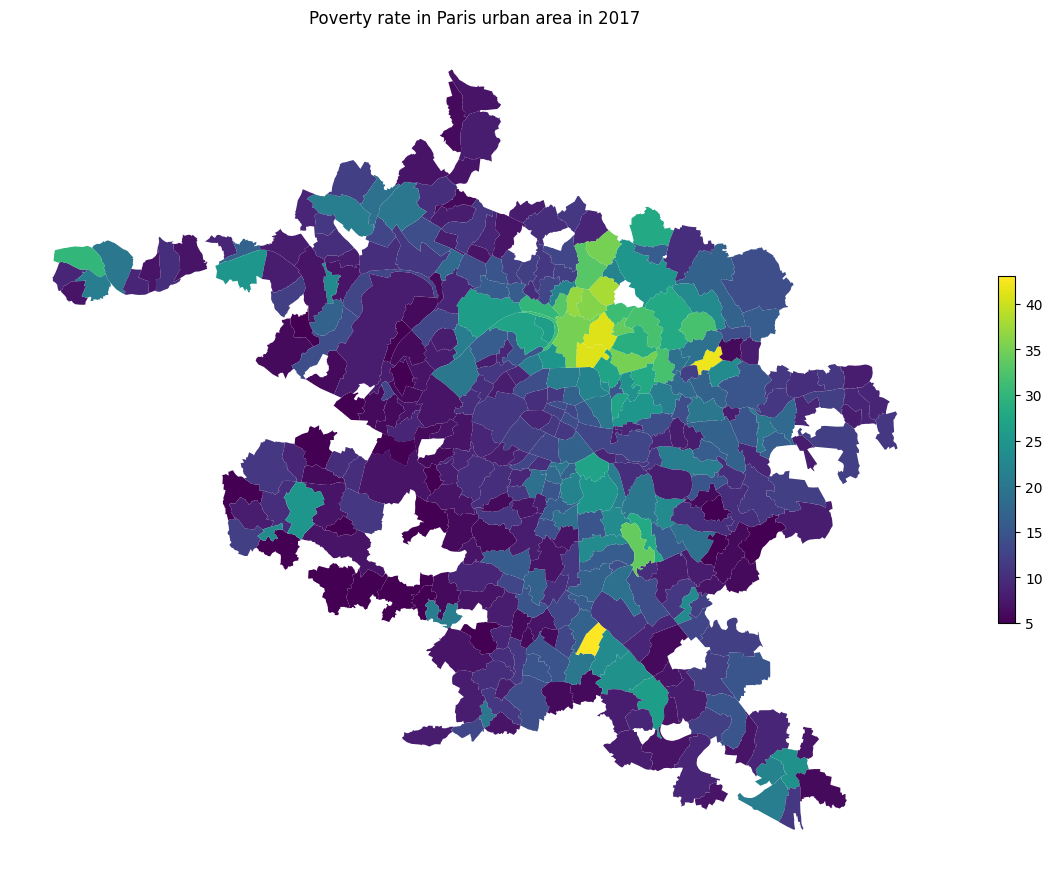

In [8]:
# merge values and geographic limits
mapparis = mapidf.merge(data_plot, how = 'right', on = 'CODEGEO')
mapparis = gpd.GeoDataFrame(mapparis).set_crs("EPSG:4326")

#plot
fig, ax = plt.subplots(1,1,figsize=(15,15))
mapparis.plot(column='OBS_VALUE', cmap=cm.viridis,  aspect=1,
    legend=True, ax=ax, legend_kwds={'shrink': 0.3})
ax.set_axis_off()
ax.set(title='Poverty rate in Paris urban area in 2017')
plt.show()
fig.savefig('poverty_paris_urban_area.svg',
            format='svg', dpi=1200,
            bbox_inches = 'tight',
            pad_inches = 0)